<a href="https://colab.research.google.com/github/toby-j/COM3025-CW/blob/main/CNN_with_Demographics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports



In [ ]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Input, BatchNormalization, Activation, concatenate
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from keras import Sequential
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import tensorflow
from sklearn import metrics

# Global functions

In [ ]:
def plot_loss(history):
  # Plotting the loss graph
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # Plotting the accuracy graph
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
def plot_confusion_matrix(model, X_test, y_test):
  y_pred = model.predict(X_test)
  y_pred_classes = np.argmax(y_pred, axis=-1)
  
  confusion_matrix = metrics.confusion_matrix(y_test, y_pred_classes)

  labels = list(set(y_test) | set(y_pred_classes))
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)

  fig, ax = plt.subplots(figsize=(10, 8))
  cm_display.plot(ax=ax)

  plt.show()

In [ ]:
def output_metrics(model, data, labels):
  predictions = model.predict(data)

  y_pred  = np.argmax(predictions, axis=-1)

  print(f'Accuracy score: {accuracy_score(labels, y_pred)}')
  print(f'F1 score: {f1_score(labels, y_pred, average="weighted")}')
  print(f'Precision score: {precision_score(labels, y_pred, average="weighted")}')
  print(f'Recall score: {recall_score(labels, y_pred, average="weighted")}')

In [ ]:
def read_and_resize_image(image_path, size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, size)
    return img

# Loading dataset

In [ ]:
!pip install -q kaggle
from google.colab import files 

In [74]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"johnk27","key":"00b3f1fe3fa0259eb805e8fe2dd1eb02"}'}

In [75]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [76]:
!cp kaggle.json ~/.kaggle/

In [77]:
!chmod 600 ~/.kaggle/kaggle.json

In [78]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [01:04<00:00, 30.2MB/s]
100% 5.20G/5.20G [01:04<00:00, 86.5MB/s]


In [79]:
!unzip -q skin-cancer-mnist-ham10000.zip -d content

replace content/HAM10000_images_part_1/ISIC_0024306.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [80]:
# Remove zip
!rm skin-cancer-mnist-ham10000.zip

In [81]:
df = pd.read_csv('content/HAM10000_metadata.csv')

In [82]:
print(df)

         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


In [83]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [84]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [85]:
df.localization.unique()

array(['scalp', 'ear', 'face', 'back', 'trunk', 'chest',
       'upper extremity', 'abdomen', 'unknown', 'lower extremity',
       'genital', 'neck', 'hand', 'foot', 'acral'], dtype=object)

# Pre-processing

In [86]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Bening keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
raw_images = 'content'

In [87]:
from glob import glob

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(raw_images, '*', '*.jpg'))}

In [88]:
print(os.path.join(raw_images, '*', '*.jpg'))

content/*/*.jpg


In [89]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [90]:
# Fill in the null values with the average age
df['age'].fillna((df['age'].mean()), inplace=True)

In [91]:
df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [92]:
df = df.dropna()

In [93]:
image_size = (128, 128)

In [94]:
# Apply the function to each image path in the 'path' column of the dataframe
df['image'] = df['path'].apply(lambda x: read_and_resize_image(x, image_size))

In [122]:
df['image'].map(lambda x: x.shape).value_counts()

(128, 128, 3)    10015
Name: image, dtype: int64

In [123]:
from sklearn.model_selection import train_test_split
# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['cell_type_idx'], random_state=42)

In [124]:
train_df = train_df.reset_index()  # make sure indexes pair with number of rows

In [125]:
print(train_df)

      index    lesion_id      image_id   dx    dx_type   age     sex  \
0      5783  HAM_0003163  ISIC_0029327   nv  follow_up  70.0  female   
1      7864  HAM_0004118  ISIC_0033443   nv      histo  30.0  female   
2       328  HAM_0007296  ISIC_0027068  bkl      histo  65.0  female   
3      8566  HAM_0007442  ISIC_0032067   nv      histo  30.0  female   
4      1401  HAM_0006635  ISIC_0029884  mel      histo  70.0    male   
...     ...          ...           ...  ...        ...   ...     ...   
8007   1312  HAM_0003782  ISIC_0027102  mel      histo  35.0  female   
8008   1816  HAM_0004754  ISIC_0033198  mel      histo  65.0    male   
8009   9501  HAM_0004071  ISIC_0033098   nv  consensus  45.0    male   
8010   6993  HAM_0006185  ISIC_0032309   nv      histo  25.0    male   
8011   2984  HAM_0000956  ISIC_0025251   nv  follow_up  45.0  female   

         localization                                             path  \
0               trunk  content/ham10000_images_part_2/ISIC_00

In [126]:
train_df['image'].map(lambda x: x.shape).value_counts()

(128, 128, 3)    8012
Name: image, dtype: int64

# Individual

In [127]:
# Extract the image data and target labels for train and test sets
X_train_img = np.stack(train_df['image'].values)
y_train = train_df['cell_type_idx'].values
X_test_img = np.stack(test_df['image'].values)
y_test = test_df['cell_type_idx'].values

In [128]:
def cnn():
  model = Sequential()
  model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Dropout(0.6))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))
  model.add(Dense(len(df['cell_type_idx'].unique()), activation='softmax'))
  return model

In [129]:
cnn = cnn()
cnn.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

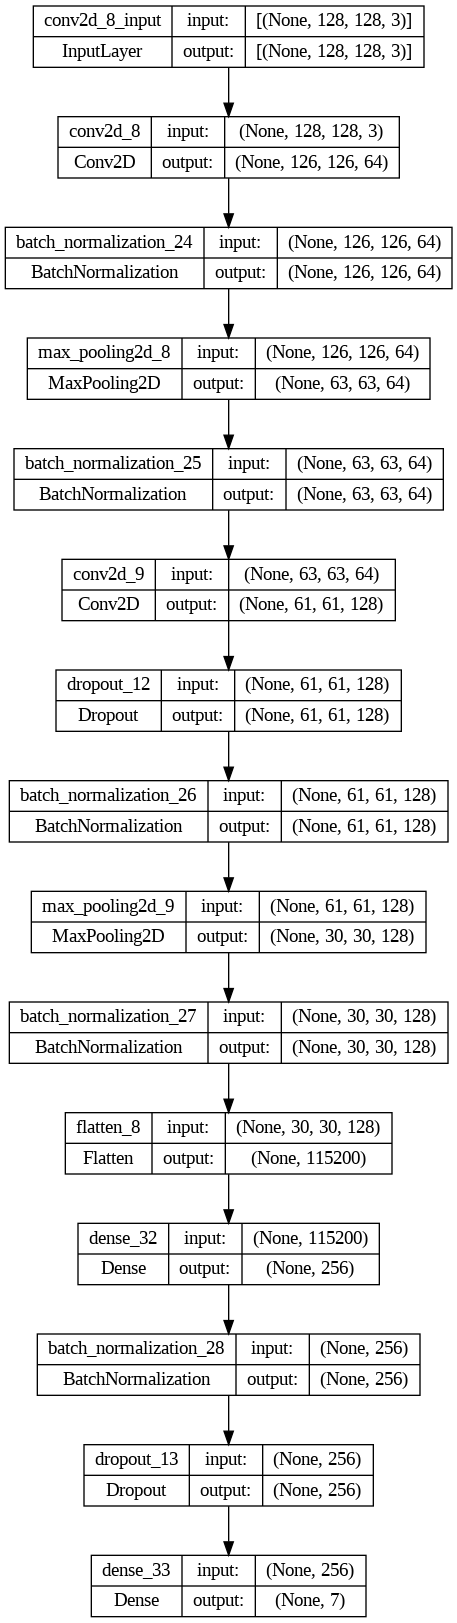

In [130]:
plot_model(cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [131]:
cnn_history = cnn.fit(X_train_img, y_train, batch_size=256, epochs=30, validation_split=0.3)

Epoch 1/30
22/22 [==============================] - 15s 580ms/step - loss: 2.6872 - accuracy: 0.4007 - val_loss: 36.4848 - val_accuracy: 0.6710
Epoch 2/30
22/22 [==============================] - 12s 566ms/step - loss: 1.7601 - accuracy: 0.5095 - val_loss: 8.7819 - val_accuracy: 0.6726
Epoch 3/30
22/22 [==============================] - 12s 540ms/step - loss: 1.3880 - accuracy: 0.6068 - val_loss: 4.7453 - val_accuracy: 0.6701
Epoch 4/30
22/22 [==============================] - 12s 533ms/step - loss: 1.1302 - accuracy: 0.6799 - val_loss: 2.7014 - val_accuracy: 0.6730
Epoch 5/30
22/22 [==============================] - 12s 533ms/step - loss: 0.9940 - accuracy: 0.7170 - val_loss: 1.2821 - val_accuracy: 0.6572
Epoch 6/30
22/22 [==============================] - 12s 559ms/step - loss: 0.8389 - accuracy: 0.7473 - val_loss: 1.3070 - val_accuracy: 0.6410
Epoch 7/30
22/22 [==============================] - 12s 557ms/step - loss: 0.7783 - accuracy: 0.7616 - val_loss: 2.1140 - val_accuracy: 0.332

In [132]:
print(y_test.shape)

(2003,)


63/63 [==============================] - 1s 11ms/step
Accuracy score: 0.7229156265601597
F1 score: 0.6873099006361059
Precision score: 0.7058780265753603
Recall score: 0.7229156265601597
63/63 [==============================] - 1s 10ms/step


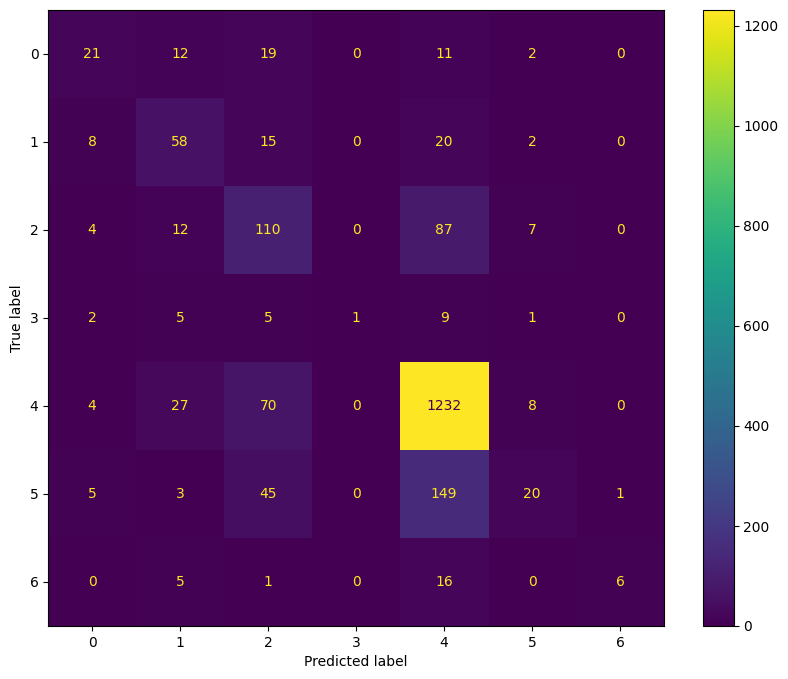

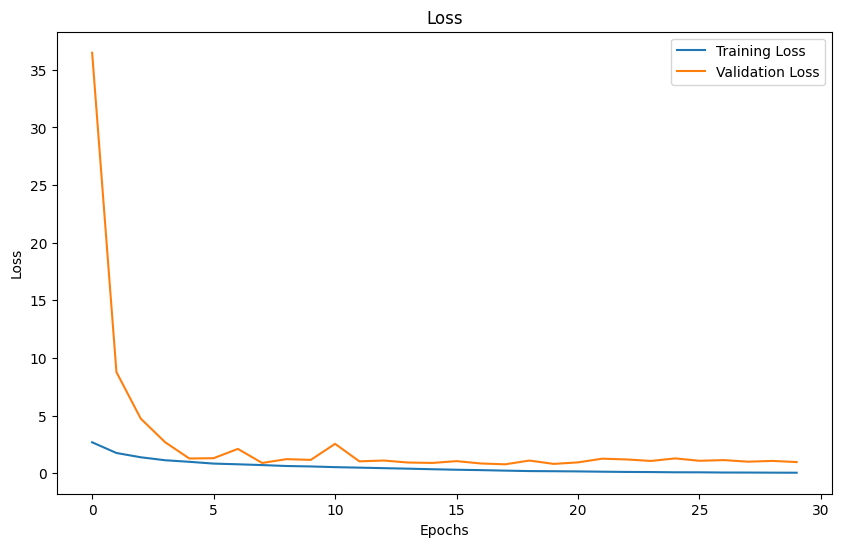

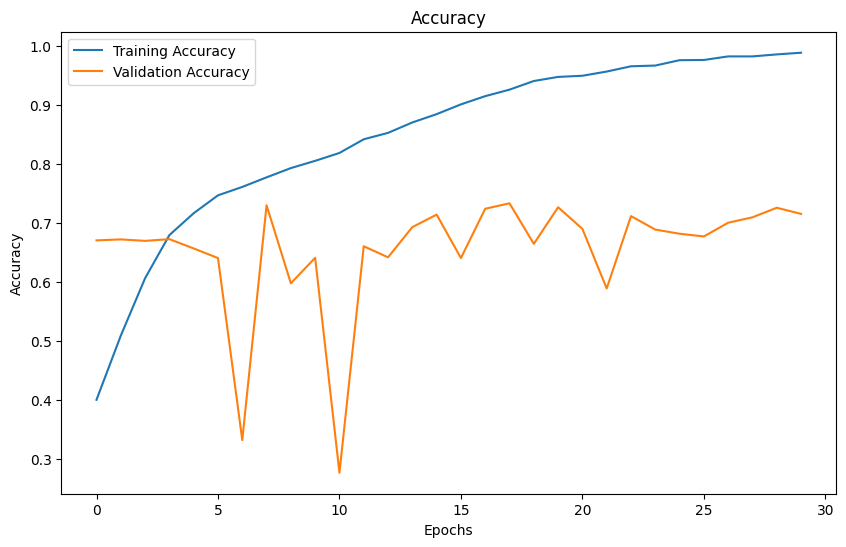

In [133]:
# Use the trained model to make predictions on the test data
output_metrics(cnn, X_test_img, y_test)
plot_confusion_matrix(cnn, X_test_img, y_test)
plot_loss(cnn_history)

In [134]:
def perceptron():
  model = Sequential()
  model.add(Input(shape=(3,)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(len(df['cell_type_idx'].unique()), activation='softmax'))
  return model

In [135]:
perceptron = perceptron()
perceptron.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

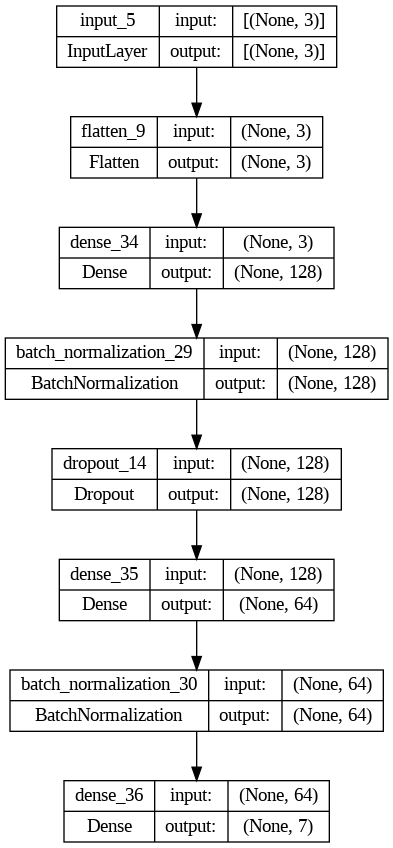

In [136]:
plot_model(perceptron, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [137]:
sex_dict = {
    'male': 0.0,
    'female': 1.0,
    'unknown': 1.5
}

loc_dict = {
    'back': 1.0,
    'lower extremity': 2.0,
    'trunk': 3.0,
    'upper extremity': 4.0,
    'abdomen': 5.0,
    'face': 6.0,
    'chest': 7.0,
    'foot': 8.0,
    'unknown': 9.0,
    'neck': 10.0,
    'scalp': 11.0,
    'hand': 12.0,
    'ear': 13.0,
    'genital': 14.0,
    'acral': 15.0
}

In [138]:
train_df = train_df.replace({"sex": sex_dict})
train_df = train_df.replace({"localization": loc_dict})
test_df = test_df.replace({"sex": sex_dict})
test_df = test_df.replace({"localization": loc_dict})

In [139]:
#Extract and recombine the demographic data for training set and test set
X_train_demo = np.stack((np.asarray(train_df['age'].values), np.asarray(train_df['sex'].values), np.asarray(train_df['localization'].values)))
y_train = train_df['cell_type_idx'].values
X_test_demo = np.stack((np.asarray(test_df['age'].values), np.asarray(test_df['sex'].values), np.asarray(test_df['localization'].values)))
y_test = test_df['cell_type_idx'].values

X_train_demo=X_train_demo.T.astype(int)
X_test_demo=X_test_demo.T.astype(int)

In [140]:
perceptron_history = perceptron.fit(X_train_demo, y_train, batch_size=256, epochs=30, validation_split=0.3)

Epoch 1/30
22/22 [==============================] - 2s 17ms/step - loss: 2.0638 - accuracy: 0.3456 - val_loss: 8.9133 - val_accuracy: 0.0641
Epoch 2/30
22/22 [==============================] - 0s 6ms/step - loss: 1.6883 - accuracy: 0.5376 - val_loss: 8.0705 - val_accuracy: 0.0828
Epoch 3/30
22/22 [==============================] - 0s 9ms/step - loss: 1.5129 - accuracy: 0.5776 - val_loss: 5.7263 - val_accuracy: 0.1776
Epoch 4/30
22/22 [==============================] - 0s 6ms/step - loss: 1.4184 - accuracy: 0.6072 - val_loss: 3.8589 - val_accuracy: 0.2687
Epoch 5/30
22/22 [==============================] - 0s 7ms/step - loss: 1.3196 - accuracy: 0.6268 - val_loss: 2.5511 - val_accuracy: 0.3898
Epoch 6/30
22/22 [==============================] - 0s 20ms/step - loss: 1.2415 - accuracy: 0.6391 - val_loss: 1.6359 - val_accuracy: 0.5258
Epoch 7/30
22/22 [==============================] - 0s 7ms/step - loss: 1.1770 - accuracy: 0.6496 - val_loss: 1.2248 - val_accuracy: 0.6073
Epoch 8/30
22/22 [

63/63 [==============================] - 0s 2ms/step
Accuracy score: 0.6814777833250125
F1 score: 0.5929739359455573
Precision score: 0.5251151163748967
Recall score: 0.6814777833250125
63/63 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


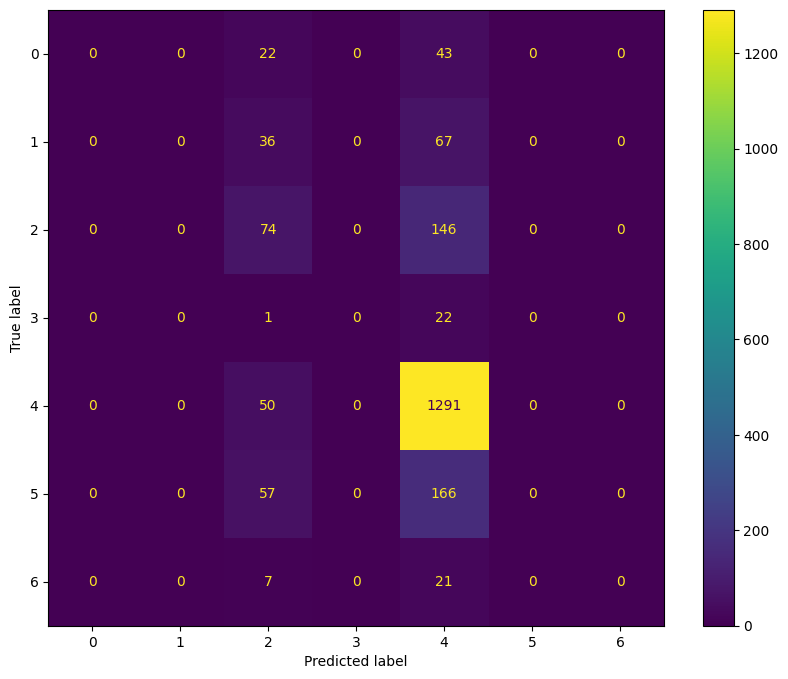

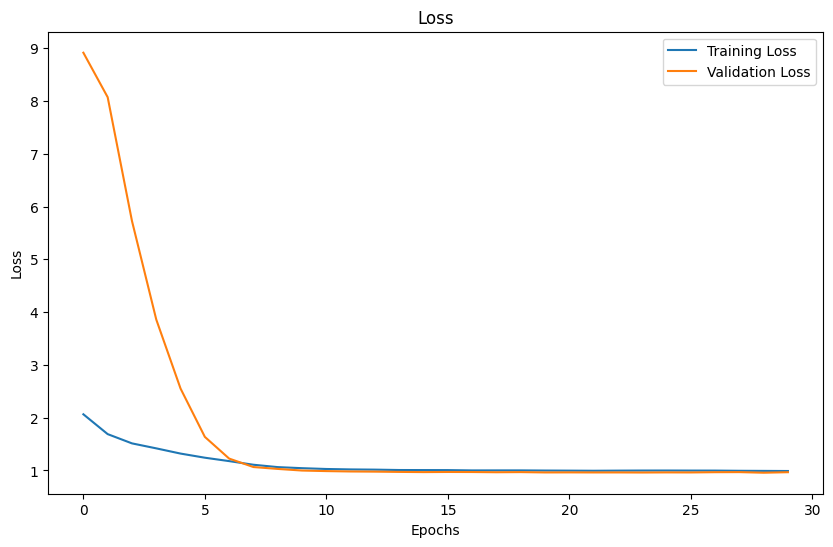

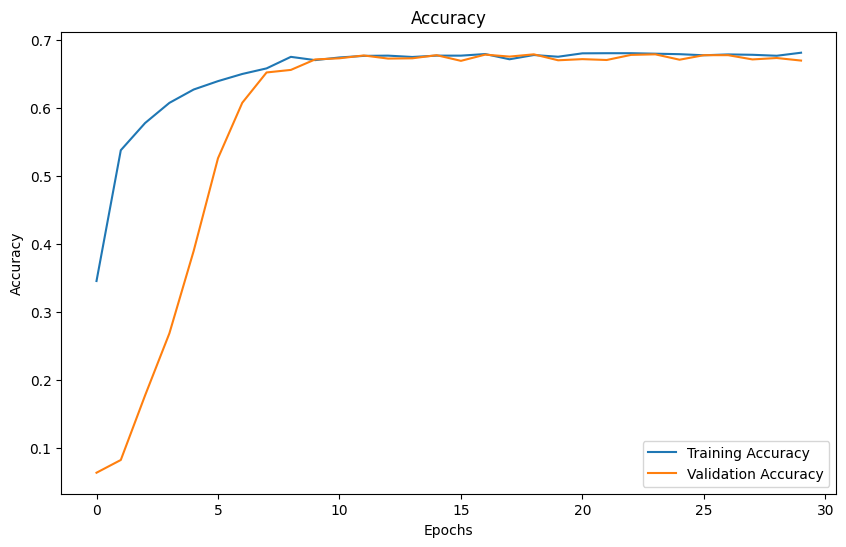

In [141]:
# Use the trained model to make predictions on the test data
output_metrics(perceptron, X_test_demo, y_test)
plot_confusion_matrix(perceptron, X_test_demo, y_test)
plot_loss(perceptron_history)

# Combined 1 - Training the combined model with the previously trained CNN and perceptron

In [142]:
concatenated_inputs = concatenate(inputs=[perceptron.output, cnn.output])
x = Dense(128, activation="relu")(concatenated_inputs)
x = Dense(64, activation="relu")(x)
x = Dense(len(df['cell_type_idx'].unique()), activation='softmax')(x)
model = Model(inputs=[perceptron.input, cnn.input], outputs=x)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [143]:
model_history = model.fit([X_train_demo, X_train_img], y_train, batch_size=256, epochs=30, validation_split=0.3)

Epoch 1/30
22/22 [==============================] - 19s 574ms/step - loss: 1.6904 - accuracy: 0.5603 - val_loss: 1.4058 - val_accuracy: 0.6710
Epoch 2/30
22/22 [==============================] - 12s 556ms/step - loss: 1.0668 - accuracy: 0.6689 - val_loss: 1.0815 - val_accuracy: 0.6710
Epoch 3/30
22/22 [==============================] - 12s 534ms/step - loss: 0.7274 - accuracy: 0.7338 - val_loss: 1.3029 - val_accuracy: 0.6136
Epoch 4/30
22/22 [==============================] - 12s 530ms/step - loss: 0.5887 - accuracy: 0.8121 - val_loss: 1.2101 - val_accuracy: 0.5724
Epoch 5/30
22/22 [==============================] - 12s 551ms/step - loss: 0.5435 - accuracy: 0.8226 - val_loss: 1.0106 - val_accuracy: 0.6951
Epoch 6/30
22/22 [==============================] - 12s 546ms/step - loss: 0.4917 - accuracy: 0.8368 - val_loss: 1.0138 - val_accuracy: 0.6988
Epoch 7/30
22/22 [==============================] - 12s 547ms/step - loss: 0.4358 - accuracy: 0.8531 - val_loss: 1.0248 - val_accuracy: 0.6997

63/63 [==============================] - 1s 11ms/step
Accuracy score: 0.6869695456814778
F1 score: 0.5796330585866184
Precision score: 0.5991487588499685
Recall score: 0.6869695456814778
 7/63 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


63/63 [==============================] - 1s 10ms/step


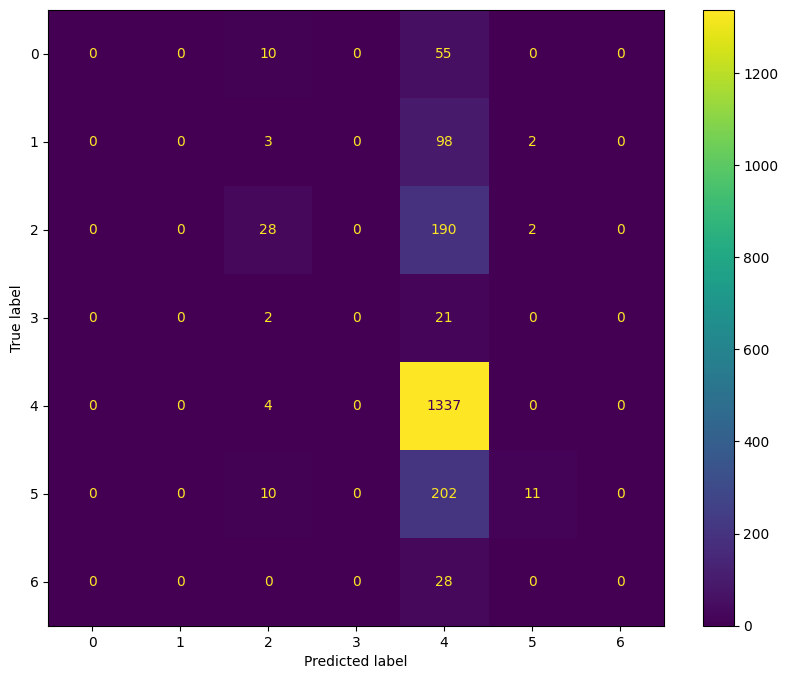

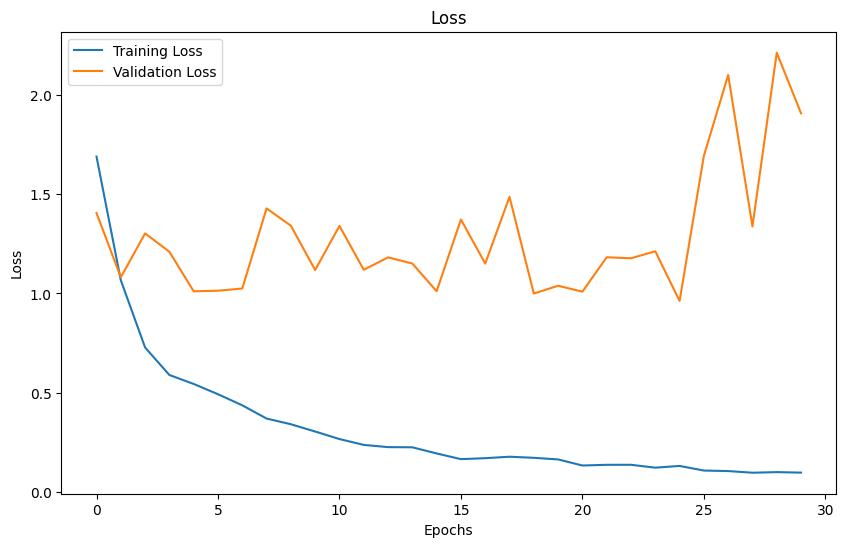

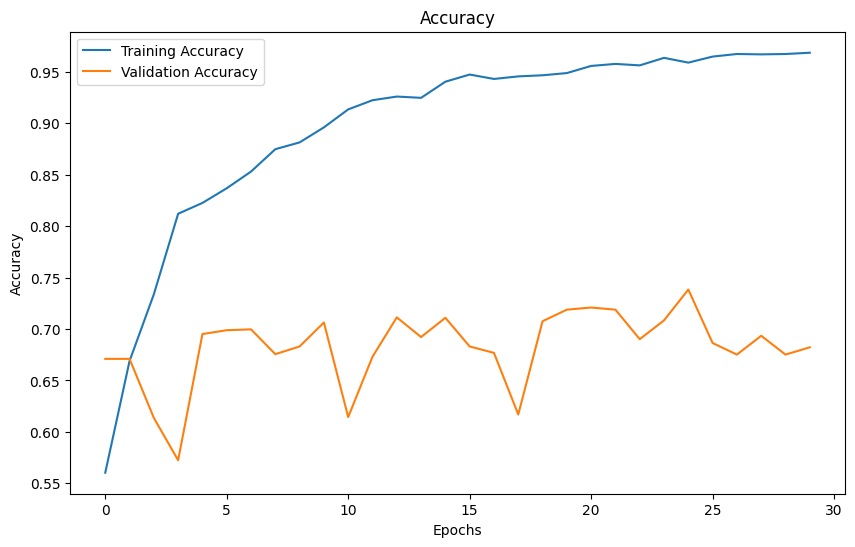

In [144]:
output_metrics(model, [X_test_demo, X_test_img], y_test)
plot_confusion_matrix(model, [X_test_demo, X_test_img], y_test)
plot_loss(model_history)

# Combined 2 - Training the combined model from scratch

In [145]:
def cnn():
  model = Sequential()
  model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Dropout(0.6))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))
  model.add(Dense(len(df['cell_type_idx'].unique()), activation='softmax'))
  return model

def perceptron():
  model = Sequential()
  model.add(Input(shape=(3,)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(len(df['cell_type_idx'].unique()), activation='softmax'))
  return model

In [146]:
perceptron = perceptron()
cnn = cnn()
#create an input for the final layers from the concatenated outputs of both subnetworks
combinedInput = concatenate(inputs=[perceptron.output, cnn.output])

#simple Multi-Layer Perceptron with Dense Layers
x = Dense(128, activation="relu")(combinedInput)
x = Dense(64, activation="relu")(x)
x = Dense(len(df['cell_type_idx'].unique()), activation='softmax')(x)
model = Model(inputs=[perceptron.input, cnn.input], outputs=x)

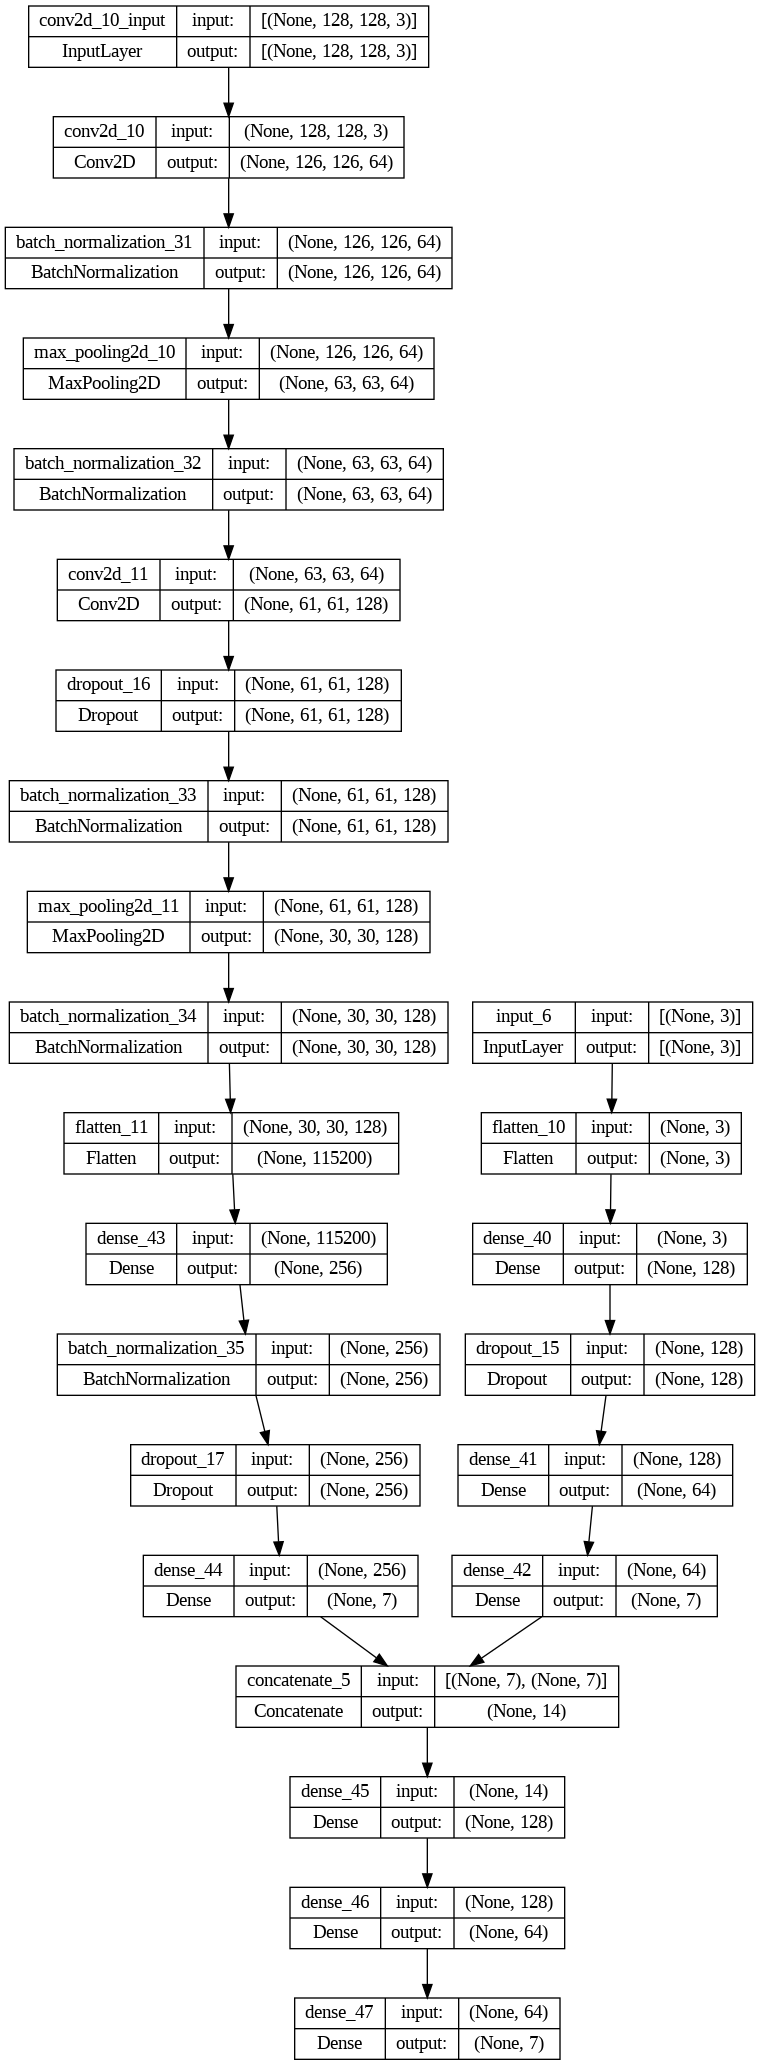

In [147]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [148]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

model_history = model.fit([X_train_demo, X_train_img], y_train, batch_size=256, epochs=30, validation_split=0.3)

Epoch 1/30
22/22 [==============================] - 18s 557ms/step - loss: 1.5089 - accuracy: 0.6038 - val_loss: 1.2342 - val_accuracy: 0.6710
Epoch 2/30
22/22 [==============================] - 12s 569ms/step - loss: 1.0651 - accuracy: 0.6689 - val_loss: 1.2839 - val_accuracy: 0.6710
Epoch 3/30
22/22 [==============================] - 12s 566ms/step - loss: 0.9562 - accuracy: 0.6689 - val_loss: 1.1056 - val_accuracy: 0.6710
Epoch 4/30
22/22 [==============================] - 12s 559ms/step - loss: 0.8987 - accuracy: 0.6715 - val_loss: 0.9680 - val_accuracy: 0.6710
Epoch 5/30
22/22 [==============================] - 12s 556ms/step - loss: 0.8563 - accuracy: 0.6899 - val_loss: 1.4791 - val_accuracy: 0.6730
Epoch 6/30
22/22 [==============================] - 12s 555ms/step - loss: 0.8305 - accuracy: 0.6826 - val_loss: 1.5599 - val_accuracy: 0.6797
Epoch 7/30
22/22 [==============================] - 12s 528ms/step - loss: 0.8136 - accuracy: 0.6835 - val_loss: 0.9351 - val_accuracy: 0.6726

63/63 [==============================] - 1s 10ms/step
Accuracy score: 0.6500249625561657
F1 score: 0.6614332960828844
Precision score: 0.7352100402524964
Recall score: 0.6500249625561657
 1/63 [..............................] - ETA: 1s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


63/63 [==============================] - 1s 10ms/step


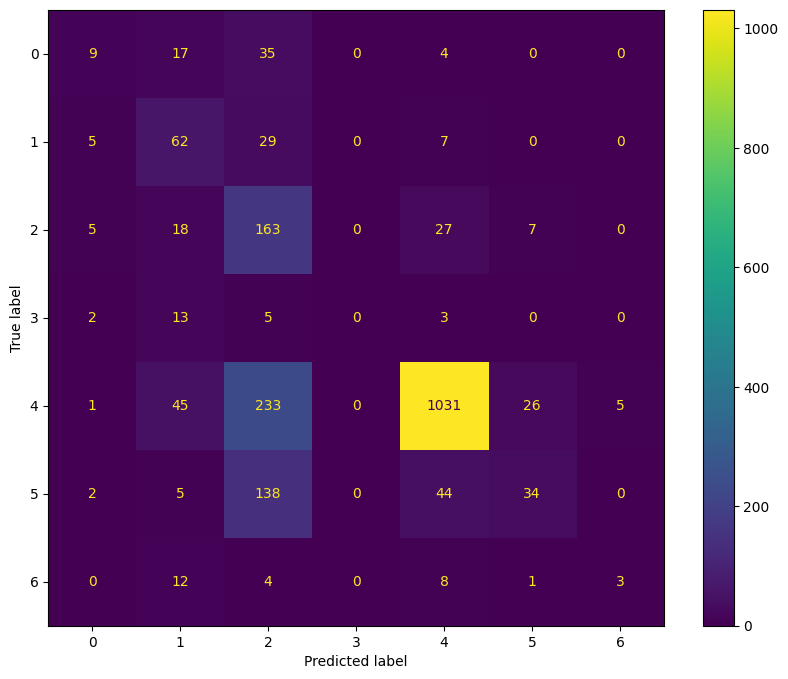

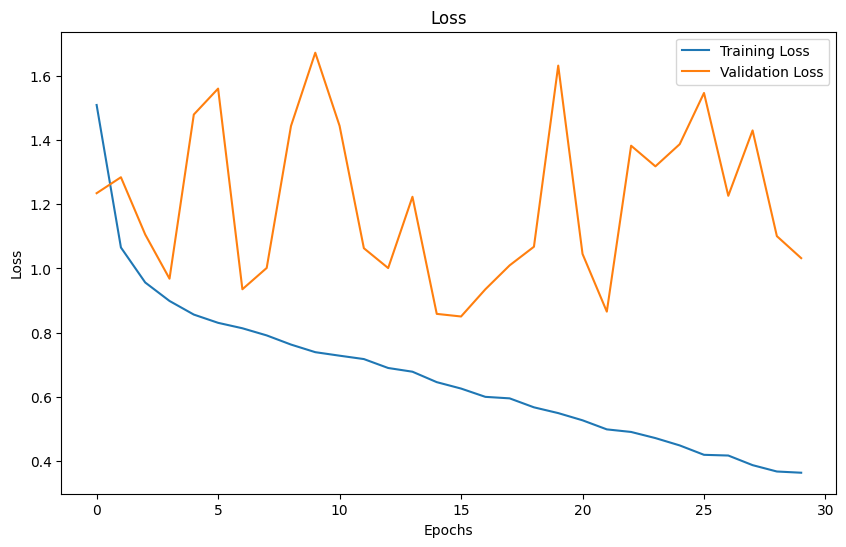

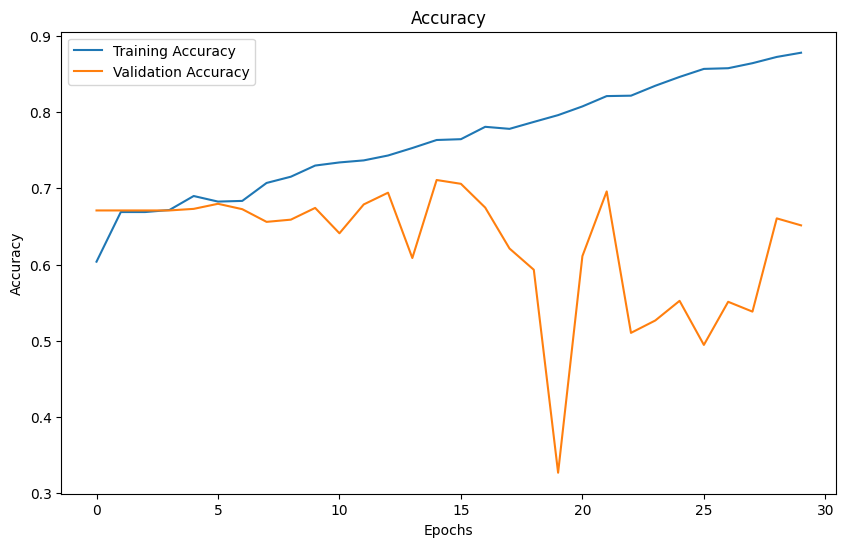

In [149]:
output_metrics(model, [X_test_demo, X_test_img], y_test)
plot_confusion_matrix(model, [X_test_demo, X_test_img], y_test)
plot_loss(model_history)